## note:
1. home all;
2. G1 X0 Y0;
3. G29 S1; Load height map from file
4. lower the z axis unitl the syringe tip touches the build plate
5. G92 Z0; set current z height as 0

### for mesh bed compensation, refer to:
https://duet3d.dozuki.com/Wiki/Using_mesh_bed_compensation

In [63]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from sys import platform

from point_in_polygon import wn_PnPoly
from pathplanner import *
from muscle_printing import *

%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
import seaborn as sns
sns.set_style("whitegrid")

# As defined in muscle_printing:
# SKIN = 2
# MUSCLE  = 1

In [32]:
TOOL = { # ratio between extruders
    CONDUCTIVE:[0, 0.5, 0, 0.5],
    MUSCLE:[0.5, 0, 0,  0.5],
    SKIN:[0, 0.5, 0.5,  0]
}
D = 22.63
# d = 1.75 # gauge14
# d = 1.15  # gauge16
d = 0.99 # guage18

# works: 'feedrate_move':600
# 'feedrate_quickmove':7000,
# 'dump_location':[160, 100, 75],
gcode_para = { # G code parameters
    'D':D,
    'd':d,
    'applied_percentage':1,
    'TOOL':TOOL,
    'dump_location':[50, 50, 30],
    'feedrate_move':600,
    'feedrate_quickmove':6000,
    'feedrate_extrude':(d**2) / (330**2),
    'total_volume_change':3820.0, # [mm^3]
    'max_reuse_volume':1450,
    }
#################################################################################################

# # for one material only!
# copied from the Soft_muscle_v2
# initial_dump_amount = 6.2

# for two material
# initial_dump_amount = 10
initial_dump_amount = 10.5

initial_gcode = ''.join([
#     'G29 S1; load probe setting\n',
    'G92 Z0;set current z as z=0\n',
    'F{0}\n'.format(gcode_para['feedrate_quickmove']),
    'G0 X{0} Y{1} Z{2}\n'.format(gcode_para['dump_location'][0],
                                 gcode_para['dump_location'][1],
                                 gcode_para['dump_location'][2]),
    multipledumping(amount = initial_dump_amount,extruder=TOOL[SKIN],feedrate_extrude = gcode_para['feedrate_extrude'],
                    delta = 0.10,wait = 400,lastWait = 6000),
    'G0 F{0:.7f}\n'.format(gcode_para['feedrate_quickmove'])])
print(initial_gcode)

G92 Z0;set current z as z=0
F6000
G0 X50 Y50 Z30
G1 F0.000009
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P400
G1 E0.0000

In [33]:
# loop to add z dimension to path_list
def add_Z(path_list,z,tool,z_g0 = None):
    """ return a list [tool,path_with_z0, path_with_z1,...]
    # z_g0 is the hight the syringe tip will go to when it start or finish a path
    @boxiXia;@jacobjoseph
    """
    if type(path_list)!=list:
        path_list = [path_list]
        
    if (type(z) is not list) and (type(z) is not np.ndarray):
        z_list = np.array([z])
    else:
        z_list = np.array(z)
        
    new_path_list = [tool]
    for z_k in z_list:
        for path in path_list:
            path_with_z =np.hstack([path,np.ones((path.shape[0],1))*z_k])

            if z_g0 is not None:
                firstPoint = [path_with_z[0,0],path_with_z[0,1],z_g0]
                lastPoint = [path_with_z[-1,0],path_with_z[-1,1],z_g0]
                path_with_z = np.vstack([firstPoint,path_with_z,lastPoint])
            new_path_list.append(path_with_z)       
            
    return(new_path_list)

def height_vector(num_layers,layer_height,z_start,a=0.85,b=0.25):
    """
    height_vector return the z height for printing each layer.
    num_layers is the total number of layer
    layer_height is the ideal layer height, usually it is the printer tip diameter
    z_start is the starting Z height
    b controls the speed of layer height transition
    a is the final layer height
    @jacobjoseph;@boxiXia
    """
    k = np.arange(0,num_layers)
    z_k = z_start + layer_height*(k*a+(1-a)*np.exp(-b)*(1-np.exp(-b*k))/(1-np.exp(-b)))
    cylinder_height = z_k[-1]-z_k[0]
    print("total_height>={0:.3f}".format(cylinder_height))
    return(z_k)

<IPython.core.display.Javascript object>


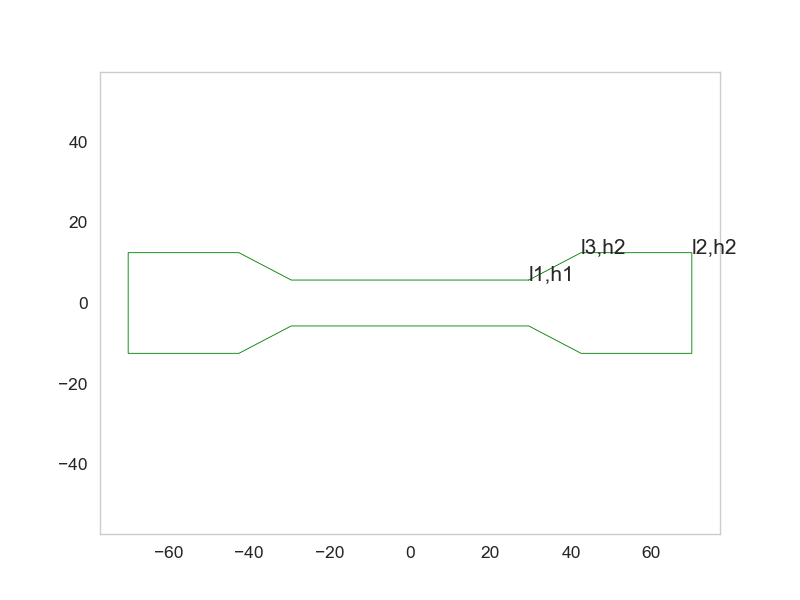

In [34]:
def DogBone(l1,l2,l3,h1,h2,x,y,plotting = False,shift = 0):
    ## example:
    # dog_bone = DogBone(l1= 20,l2=50,l3= 30,h1=10,h2=20,x= 0,y= 0,plotting=True)
    #
    dog_bone = np.array([[l1/2+x,h1/2+y],
                         [l3/2+x,h2/2+y],
                         [l2/2+x,h2/2+y],
                         [l2/2+x,-h2/2+y],
                         [l3/2+x,-h2/2+y],
                         [l1/2+x,-h1/2+y],
                         [-l1/2+x,-h1/2+y],
                         [-l3/2+x,-h2/2+y],
                         [-l2/2+x,-h2/2+y],
                         [-l2/2+x,h2/2+y],
                         [-l3/2+x,h2/2+y],
                         [-l1/2+x,h1/2+y]])
    if shift!=0:
        dog_bone = np.roll(dog_bone,shift,axis = 0 )
    dog_bone =np.vstack((dog_bone,dog_bone[0]))
    if plotting:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(dog_bone[:,0],dog_bone[:,1],color ='g',linewidth = 0.5)
        # for k in range(len(dog_bone)-1):
        #     ax.text(dog_bone[k,0],dog_bone[k,1], k, 
        #         fontsize=12,horizontalalignment='center',verticalalignment = 'center')
        ax.text(dog_bone[0,0],dog_bone[0,1], 'l1,h1', fontsize=12)
        ax.text(dog_bone[1,0],dog_bone[1,1], 'l3,h2', fontsize=12)
        ax.text(dog_bone[2,0],dog_bone[2,1], 'l2,h2', fontsize=12)
        plt.axis('equal');plt.grid();plt.show();
    return dog_bone

def StandardDogBone(x,y,Die,plotting=False,shift = 0):
    if Die =='A': 
        # For ASTM D412-16 Die A
        l1=59
#         l3 = 74 # for 45 degree angle from inner to outer rectangle
        l3 = 84.98 # for 30 degree angle from inner to outer rectangle
        l2=140
        h1=11.4
        h2=25
    elif Die =='C':
        # For ASTM D412-16 Die C
        l1=59
        #  l3 = 74 # for 45 degree angle from inner to outer rectangle
        l3 = 84.98 # for 30 degree angle from inner to outer rectangle
        l2=115
        h1=5.4
        h2=25
    # height of ASTM D412-16 Die A is 3 mm
    return DogBone(l1,l2,l3,h1,h2,x,y,plotting,shift)
dog_bone = StandardDogBone(0,0,'A',plotting=True)

In [5]:
def plotPath(lines):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(lines[:,0],lines[:,1],color ='g',linewidth = 0.5)
    for k in range(len(lines)-1):
        ax.text(lines[k,0],lines[k,1], k, 
            fontsize=12,horizontalalignment='center',verticalalignment = 'center')
    plt.axis('equal');plt.grid();plt.show();

feedrate_extrude=9e-06


<IPython.core.display.Javascript object>


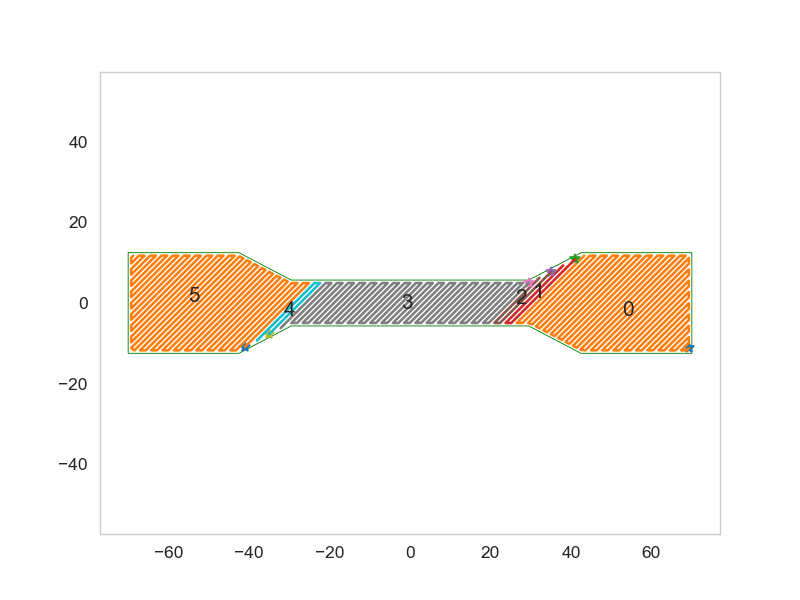

<IPython.core.display.Javascript object>


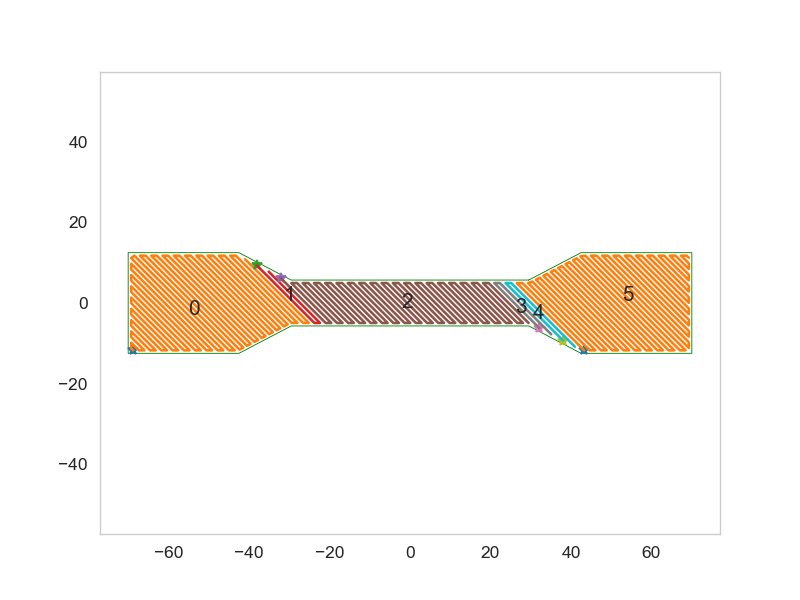

<IPython.core.display.Javascript object>


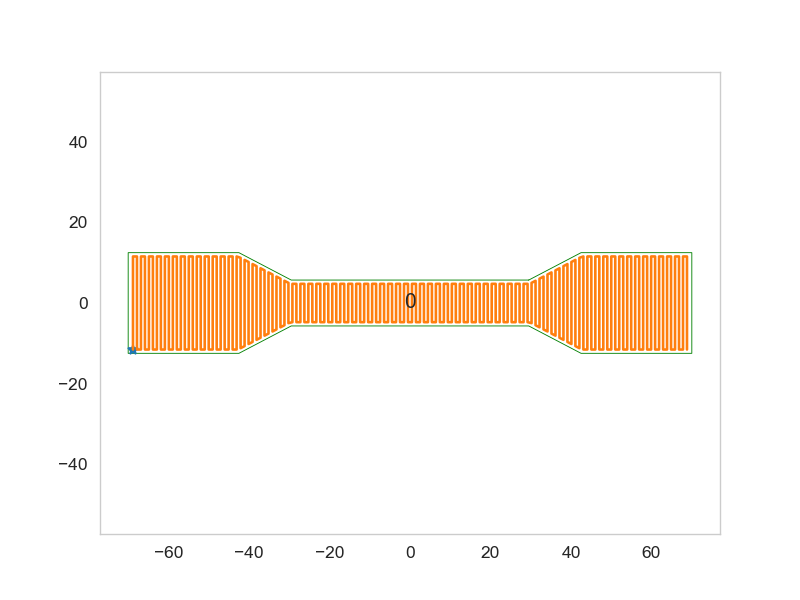

<IPython.core.display.Javascript object>


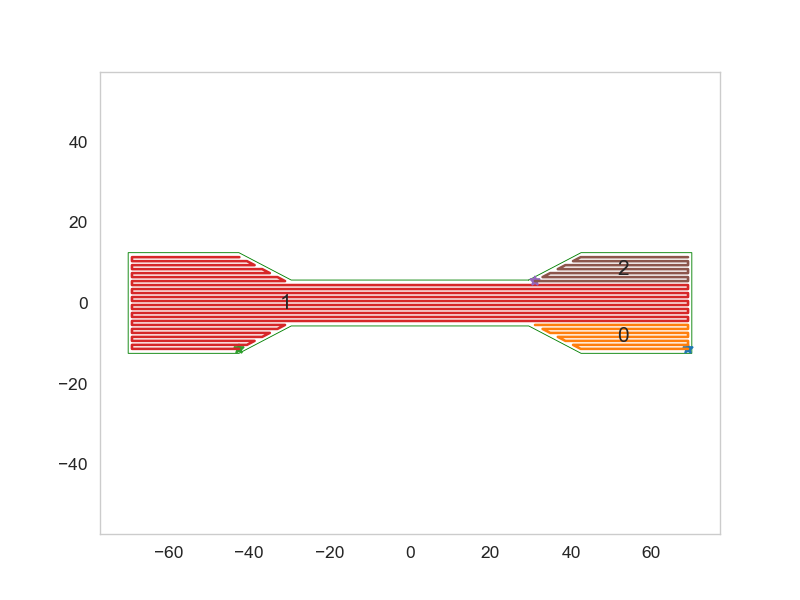

'Done'

In [35]:
###################################################################################################
print('feedrate_extrude={}'.format(gcode_para['feedrate_extrude']))

########################################################################
polygon_path(dog_bone,d,plotting=True,angle=np.pi/4*3)
polygon_path(dog_bone,d,plotting=True,angle=np.pi/4)
polygon_path(dog_bone,d,plotting=True,angle=0)
polygon_path(dog_bone,d,plotting=True,angle=np.pi/2)
'Done'

In [7]:
#script to
def criss_cross(dog_bone, d, num_layers, z, tool,plotting = False):
    # function to generate cris-cross pattern infill only,
    # not including the outline
    # num_layers<len(z)
    # return a path list consisting of
    # [[tool,path_opt[0]with_Z[0]]
    #  [tool,path_opt[1]with_Z[1]]
    #  [tool,path_opt[0]with_Z[2]]
    #  [tool,path_opt[1]with_Z[3]]
    #  .......] of num_layers elements
    lines_list_diag = []
    path_opt = [
        polygon_path(dog_bone, d, plotting= plotting, angle=np.pi / 4*3),
        polygon_path(dog_bone, d, plotting= plotting, angle=np.pi / 4)
    ]
    for i in range(num_layers):
        path = path_opt[i % 2]
        lines_list_diag.append(add_Z(path, z[i], tool))
    # insert point at begining
    firstPoint = lines_list_diag[0][1][0]
    lines_list_diag[0][1] =  np.vstack([[firstPoint[0],firstPoint[1],z[-1]],lines_list_diag[0][1]])
    # append point at last
    lastPoint = lines_list_diag[-1][-1][-1]
    lines_list_diag[-1][-1] = np.vstack([lines_list_diag[-1][-1],[lastPoint[0],lastPoint[1],z[-1]]])
        
    return (lines_list_diag)


# lines_list_diag = criss_cross(dog_bone, d, num_layers, z, SKIN,plotting = False)


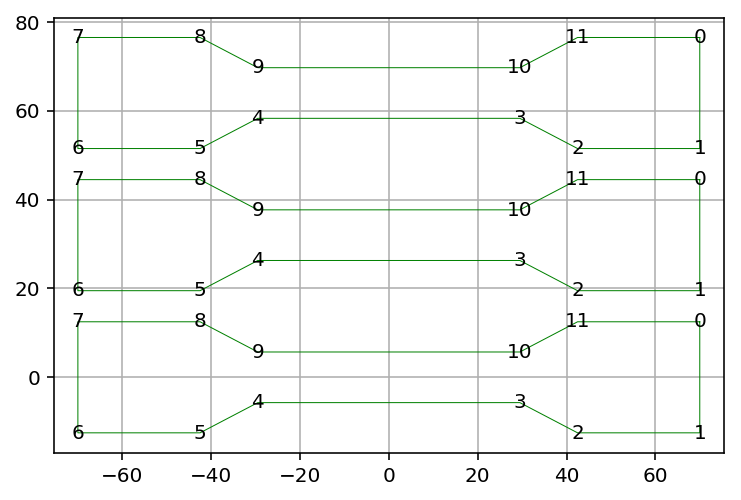

In [8]:
dx = 145
dy = 32
x0 = 0
# y0 = -dy*2 # for 3
y0 = -dy # for 1
dog_bone_list = [StandardDogBone(x0+dx*i,y0+dy*j,'A',shift = -2) for i in range(1) for j in range(1,4)]
fig = plt.figure()
ax = fig.add_subplot(111)
for lines in dog_bone_list:
    ax.plot(lines[:,0],lines[:,1],color ='g',linewidth = 0.5)
    for k in range(len(lines)-1):
        ax.text(lines[k,0],lines[k,1], k, 
            fontsize=10,horizontalalignment='center',verticalalignment = 'center')
plt.axis('equal');plt.grid();plt.show();

In [36]:
# define infill_style option
VERTICLE = 0
HORIZONRAL = 1
CRISSCROSS = 2
######################################

infill_style = HORIZONRAL
num_layers = 6
z_start = 0.5
z = height_vector(num_layers, d, z_start)
print("z vector = ")
print(z)
num_offset = 2
################################################
lines_list = []
wall_list = [
    np.vstack([
        offset_lines(lines, d * float(k), left=True) for k in range(num_offset)
    ]) for lines in dog_bone_list
]
for z_i in z:
#     for k in range(len(dog_bone_list)):# for 3 styles
    for k in range(1):# for 1 style
        lines_list.append(add_Z(wall_list[k], z_i, SKIN))

# print dog_bone with infill style specified by the infill_style_list
# infill_style_list = [CRISSCROSS,VERTICLE,HORIZONRAL] # for 3 styles
infill_style_list = [CRISSCROSS] # for 1 style
for k,infill_style in enumerate(infill_style_list):
    dog_bone = dog_bone_list[k]
    if infill_style== CRISSCROSS:
        lines_list.extend(
            criss_cross(
                dog_bone,
                d,
                num_layers, z,
                tool=MUSCLE,
                plotting=False))
    else:
        infill = polygon_path(dog_bone, d, plotting= False, angle=np.pi/2*infill_style)
        lines_list.append(add_Z(infill,z,MUSCLE,z_g0=z[-1]))

total_height>=4.581
z vector = 
[0.5        1.45715192 2.38872172 3.30036815 4.19649825 5.08054421]


<IPython.core.display.Javascript object>


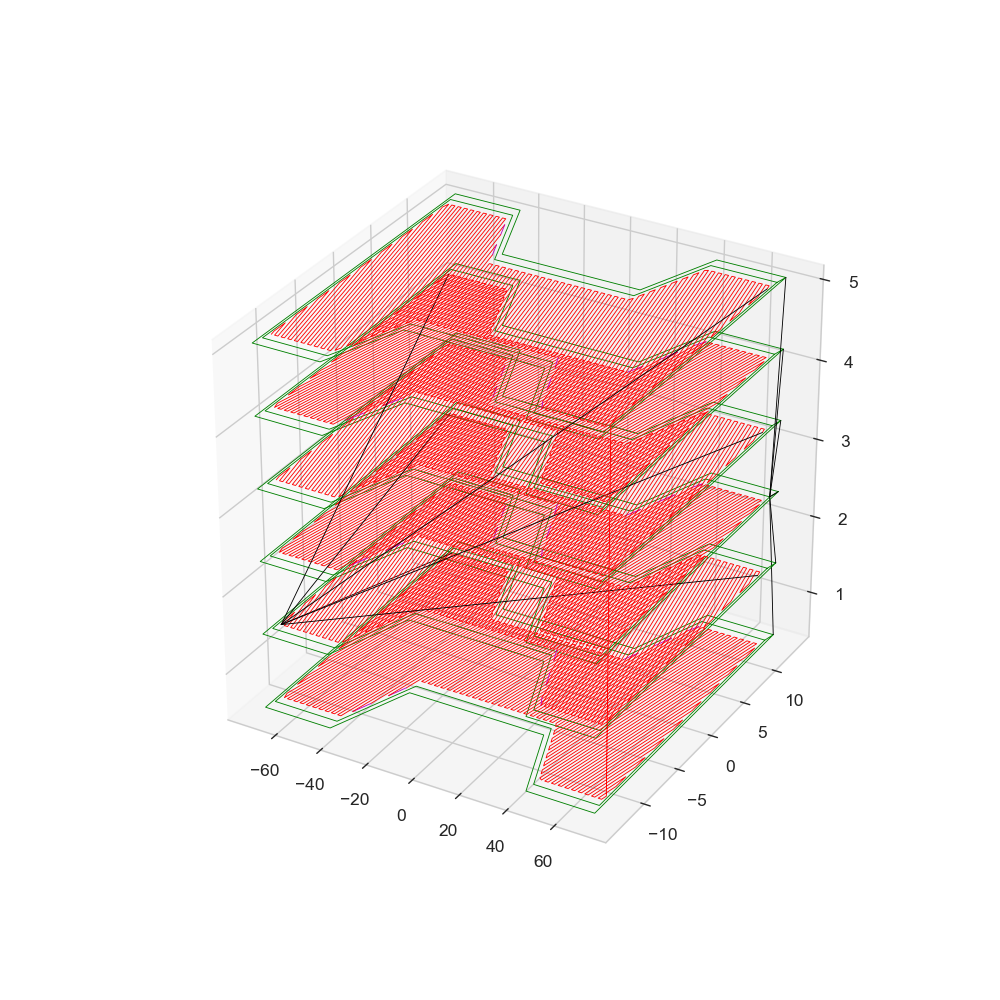

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for i,lines in enumerate(lines_list):
    for k in range(1,len(lines)):
        ax.plot(lines[k][:,0],lines[k][:,1],lines[k][:,2],c=COLORS[lines[0]],linewidth=.5)
        try:
            ax.plot([lines[k][-1,0],lines[k + 1][0,0]],[lines[k][-1,1],lines[k + 1][0,1]],[lines[k][-1,2],lines[k + 1][0,2]],'m',linewidth=.5)
        except IndexError:
#             try:
            last_point = lines[-1][-1]
            next_point = lines_list[k+1][1][0]
#             connect = np.vstack([lines[k][-1],lines_list[k+1][1][0]])
            ax.plot([last_point[0],next_point[0]],[last_point[1],next_point[1]],[last_point[2],next_point[2]],c = 'k',linewidth=.5)

plt.show()

In [11]:
g_code_strings = lines_list_to_gcode_strings(lines_list,gcode_para)  

# initialization
g_code_strings.insert(0,initial_gcode)

s = ''.join(g_code_strings)
if platform == 'win32':
    f = open('gcode/dog_bones.g','w')
else:
    f = open('gcode/dog_bones.g','w')
f.write(s)
f.close()
# print(s)

In [38]:
def sinebox(offset_x = -20,offset_y = 0):
    l_x = 46.5
    l_y = 1.6
    n_wave = 5
    n_points = 50
    x = np.linspace(0,l_x,n_points)
    y = np.sin(np.linspace(0,n_wave*np.pi,n_points))*l_y
    # plot
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(x,y)
#     plt.axis("equal")
#     plt.grid()
#     plt.show()
    h = 15
    line = np.empty((int(n_points*2+1),2))
    line[:,0]=np.hstack([x,np.flip(x,0),[0]])+offset_x
    line[:,1]=np.hstack([y+h/2,-np.flip(y,0)-h/2,[h/2]])+offset_y
    
    
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(line[:,0],line[:,1])
#     plt.axis("equal")
#     plt.grid()
#     plt.show()
    return line

In [39]:
sinebox()

array([[-20.        ,   7.5       ],
       [-19.05102041,   8.00417315],
       [-18.10204082,   8.45697685],
       [-17.15306122,   8.81227561],
       [-16.20408163,   9.03386856],
       [-15.25510204,   9.09917795],
       [-14.30612245,   9.00154948],
       [-13.35714286,   8.75093037],
       [-12.40816327,   8.37285584],
       [-11.45918367,   7.90584733],
       [-10.51020408,   7.39748765],
       [ -9.56122449,   6.89957279],
       [ -8.6122449 ,   6.46283457],
       [ -7.66326531,   6.13177158],
       [ -6.71428571,   5.94011534],
       [ -5.76530612,   5.90739342],
       [ -4.81632653,   6.0369398 ],
       [ -3.86734694,   6.3155552 ],
       [ -2.91836735,   6.71485192],
       [ -1.96938776,   7.19414619],
       [ -1.02040816,   7.70460346],
       [ -0.07142857,   8.19421398],
       [  0.87755102,   8.61309208],
       [  1.82653061,   8.91855889],
       [  2.7755102 ,   9.07949085],
       [  3.7244898 ,   9.07949085],
       [  4.67346939,   8.91855889],
 

In [40]:
h2=10
# script for mulitple sets of walls and muscle in one print TEST
# lines_list_vert = []
# lines_list_walls = []
lines_lists = []
x = -46.5/2
num_offset = 3
y = 0
dog_bone = sinebox(x,y)


# infills
path_list_infill_muscle = polygon_path(dog_bone,d,plotting=False,angle=0)
path_list_infill_muscle = np.vstack((path_list_infill_muscle[0][0],path_list_infill_muscle[0],path_list_infill_muscle[0][-1]))
path_list_infill_muscle_flip = np.flip(path_list_infill_muscle,0)

path_list_infill_skin = polygon_path(offset_lines(dog_bone,d*0.2,left = True),d,plotting=False,angle=0)
path_list_infill_skin = np.vstack((path_list_infill_skin[0][0],path_list_infill_skin[0],path_list_infill_skin[0][-1]))
path_list_infill_skin_flip=np.flip(path_list_infill_skin,0)
# walls
path_list_wall =np.vstack([offset_lines(dog_bone,d*float(k+0.1),left = True) for k in range(num_offset)])



lines_lists.append(add_Z(path_list_wall,z[0],SKIN)) # first layer of wall
lines_lists.append(add_Z(path_list_infill_muscle,z[0],SKIN,z_g0=z[-1])) # fist layer of infill 
lines_lists.append(add_Z(path_list_wall,z[1:],SKIN,z_g0=z[-1])) # the rest lyer of wall
for i,z_i in enumerate(z[1:-1]):
    if i%2==1:
        lines_lists.append(add_Z(path_list_infill_muscle,z_i,MUSCLE,z_g0=z[-1])) 
    else:
        lines_lists.append(add_Z(path_list_infill_muscle_flip,z_i,MUSCLE,z_g0=z[-1])) 
# lines_lists.append(add_Z(path_list_infill_muscle,z[1:-1],MUSCLE,z_g0=z[-1])) 
lines_lists.append(add_Z(path_list_infill_skin_flip,z[-1],SKIN,z_g0=z[-1]+0.5)) # top layer of infill-skin





#lines_list_walls = [lines_list_walls]
g_code_strings = lines_list_to_gcode_strings(lines_lists,gcode_para)
for gcode in g_code_strings:
    print(gcode)
# initialization
g_code_strings.insert(0,initial_gcode)
#print(g_code_strings)
s = ''.join(g_code_strings)
if platform == 'win32':
    f = open('./gcode/dog_bones_muscle.g','w')
    print("win32")
    
else:
    f = open('/Users/davidjoseph/Google Drive/3D printing soft muscle/G-Code/dog_bones_muscle.g','w')
f.write(s)
f.close()
#print(s)

G0 X-23.349000 Y7.559508 Z0.500000 F6000
G1 X-22.345582 Y8.092603 Z0.500000 E0.000000:0.001087:0.001087:0.000000 F600
G1 X-21.390787 Y8.548182 Z0.500000 E0.000000:0.001012:0.001012:0.000000 F600
G1 X-20.431792 Y8.907230 Z0.500000 E0.000000:0.000980:0.000980:0.000000 F600
G1 X-19.468831 Y9.132088 Z0.500000 E0.000000:0.000946:0.000946:0.000000 F600
G1 X-18.503423 Y9.198528 Z0.500000 E0.000000:0.000926:0.000926:0.000000 F600
G1 X-17.538310 Y9.099239 Z0.500000 E0.000000:0.000928:0.000928:0.000000 F600
G1 X-16.576070 Y8.845118 Z0.500000 E0.000000:0.000952:0.000952:0.000000 F600
G1 X-15.617925 Y8.463392 Z0.500000 E0.000000:0.000987:0.000987:0.000000 F600
G1 X-14.663940 Y7.993920 Z0.500000 E0.000000:0.001017:0.001017:0.000000 F600
G1 X-13.713831 Y7.484956 Z0.500000 E0.000000:0.001031:0.001031:0.000000 F600
G1 X-12.767502 Y6.988432 Z0.500000 E0.000000:0.001023:0.001023:0.000000 F600
G1 X-11.825161 Y6.554749 Z0.500000 E0.000000:0.000993:0.000993:0.000000 F600
G1 X-10.887039 Y6.227474 Z0.500000 

In [93]:
def plot_lines_list(lines_list):
    """plot given a lines_list,which is in the format of 
    [[Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    [Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    [Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    .....
    ]
    @boxiXia
    """
    fig = plt.figure(figsize=(3,3),dpi=600)
    ax = fig.add_subplot(111, projection='3d')
    for lines in lines_list:
        for k in range(1,len(lines)):
            ax.plot(lines[k][:,0],lines[k][:,1],lines[k][:,2],c=COLORS[lines[0]],linewidth=.5)
            try:
                ax.plot([lines[k][-1,0],lines[k + 1][0,0]],[lines[k][-1,1],lines[k + 1][0,1]],[lines[k][-1,2],lines[k + 1][0,2]],'m',linewidth=.5)
            except IndexError:
                #last lines
                pass
    ax.axis('equal')
    return ax

In [94]:
%matplotlib inline


[]

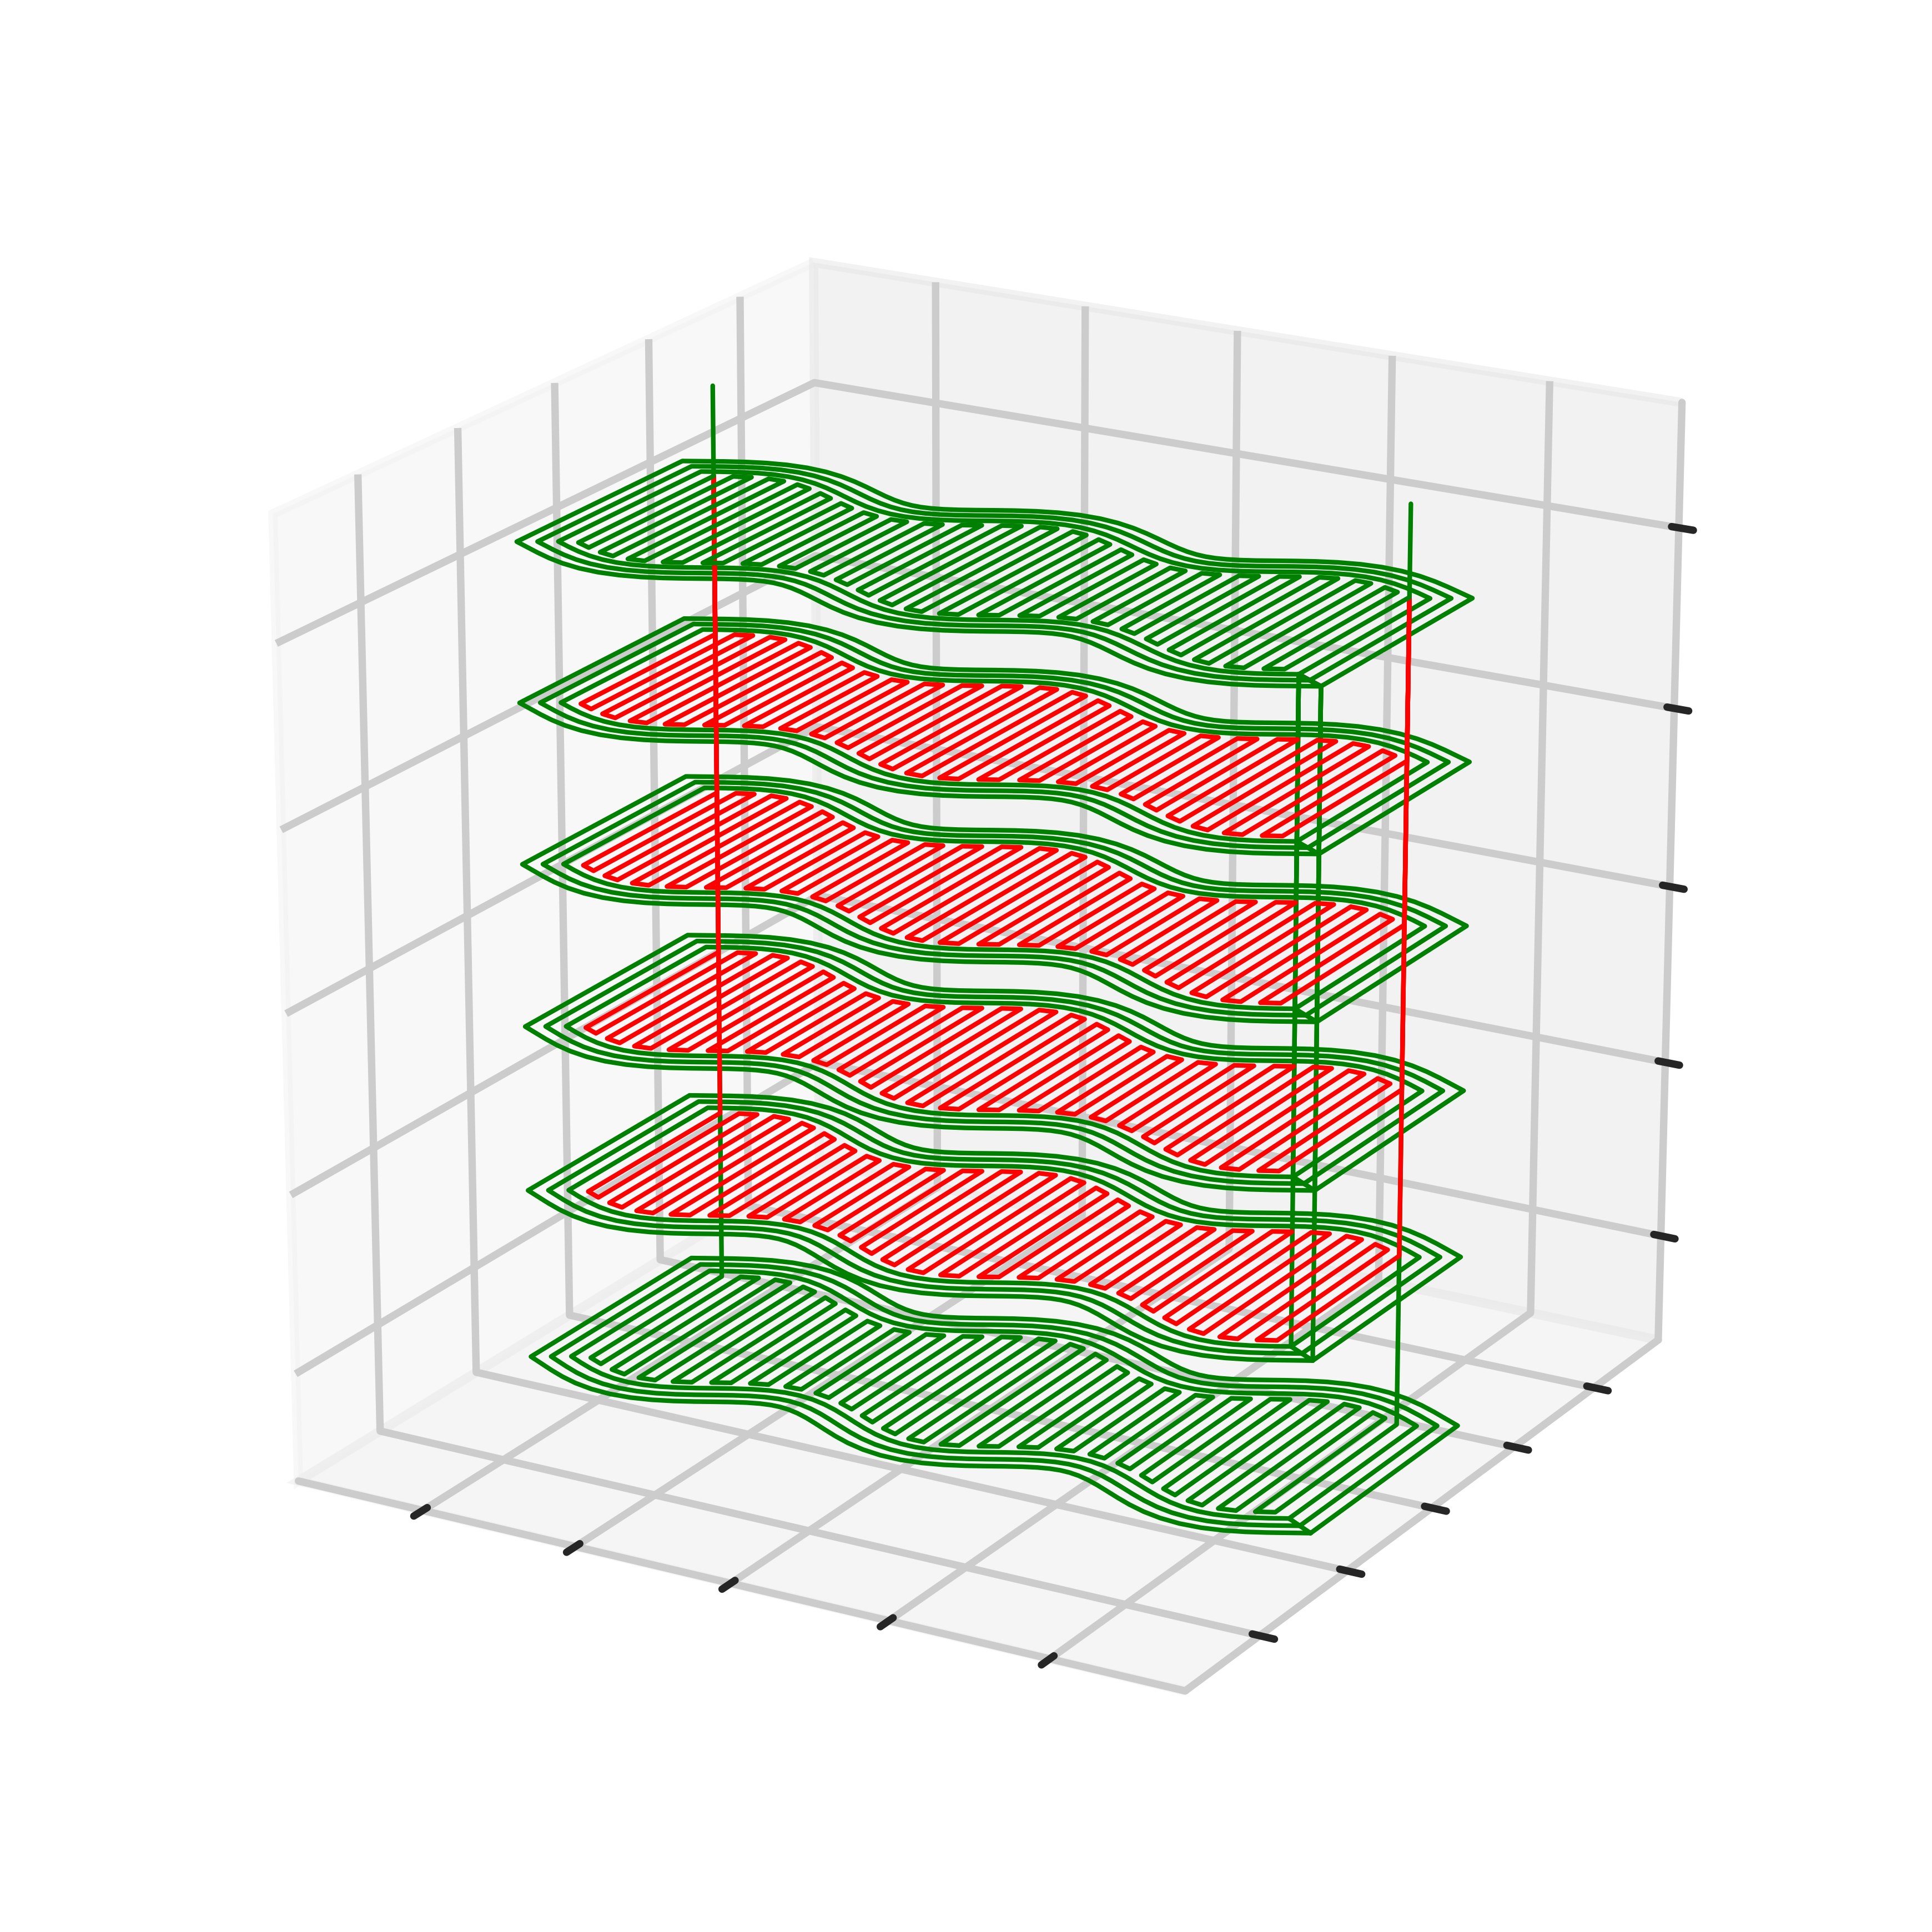

In [104]:
ax = plot_lines_list(lines_lists)
# ax.plot(np.zeros(2),np.zeros(2),[0,20],alpha=0)
# ax.set_zlim3d(0,6)
plt.tight_layout()
ax.view_init(elev=20., azim=120)
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

In [15]:
path_list_infill_muscle

array([[-22.277325  ,  -7.17597868],
       [-22.277325  ,  -7.17597868],
       [-22.277325  ,   7.17597868],
       [-21.287325  ,   7.66516379],
       [-21.287325  ,  -7.66516379],
       [-20.297325  ,  -8.05902909],
       [-20.297325  ,   8.05902909],
       [-19.307325  ,   8.29971218],
       [-19.307325  ,  -8.29971218],
       [-18.317325  ,  -8.33344108],
       [-18.317325  ,   8.33344108],
       [-17.327325  ,   8.17316908],
       [-17.327325  ,  -8.17316908],
       [-16.337325  ,  -7.84417781],
       [-16.337325  ,   7.84417781],
       [-15.347325  ,   7.39234817],
       [-15.347325  ,  -7.39234817],
       [-14.357325  ,  -6.8750347 ],
       [-14.357325  ,   6.8750347 ],
       [-13.367325  ,   6.35285296],
       [-13.367325  ,  -6.35285296],
       [-12.377325  ,  -5.88252638],
       [-12.377325  ,   5.88252638],
       [-11.387325  ,   5.51076709],
       [-11.387325  ,  -5.51076709],
       [-10.397325  ,  -5.2700809 ],
       [-10.397325  ,   5.2700809 ],
 

In [16]:
# a = [square(start = (0,0,0),l=100+10*k,d=2,n=1)[0] for k in range(20)]


# lines_list = [[0,a[0],a[1],a[2]],[0,a[3],a[4],a[5]],[1,a[6],a[7],a[8]],[1,a[9],a[10],a[11]]]
# %matplotlib notebook
# plot_lines_list(lines_list)
# g_code_strings = lines_list_to_gcode_strings(lines_list,gcode_para)
# for gcode in g_code_strings:
#     print(gcode)
# # dumping:
# g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:3.5:3.5:0 F0.4624\nG4 P6000\nG0 F1800')
# # initialization
# g_code_strings.insert(0,init)
# #print(g_code_strings)
# s = ''.join(g_code_strings)
# if platform == 'win32':
#     f = open('D:/Google Drive/3D printing soft muscle/G-Code/dog_bones_muscle.g','w')
# else:
#     f = open('/Users/davidjoseph/Google Drive/3D printing soft muscle/G-Code/dog_bones_muscle.g','w')
# f.write(s)
# f.close()